# Predicting All-NBA selections using a Logistic Regression Model

We are going to be using data from https://www.basketball-reference.com to train and test our model, as well as predict the 2022-23 All-NBA selections.

Every year, after the end of the NBA season, the best players of the season are selected in the All-NBA teams.

Until the 1987-88 season, only 10 players were selected in those teams, forming the All-NBA 1st and 2nd teams. Starting 1988-89, a 3rd team was added, increasing the number of selections to 15.

For that reason, we will be working with data from the 1988-89 season until the 2021-22 season to train and test the model. To predict this season's All-NBA selections, we will use real-time data, to give as up-to-date predictions as possible.

# Data Scraping

In [1]:
#import all necessary libraries
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

We will first create the functions that will later help us obtain the necessary data.

In [2]:
#URL creator

def URL_creator(Year, Advanced = False):
    if Advanced == False:
        url="https://www.basketball-reference.com/leagues/NBA_"+str(Year)+"_per_game.html"
    else:
        url="https://www.basketball-reference.com/leagues/NBA_"+str(Year)+"_advanced.html"
    return url

In [3]:
#Web scraping for individual stats

def find_stats(url, season, Advanced = False):
    # collect HTML data
    html = urlopen(url)
    # create beautiful soup object from HTML
    soup = BeautifulSoup(html, features="lxml")
    
    #Extract information #1
    info = soup.findAll('th')
    #Find the column names
    lista=[]
    [lista.append(head.text) for head in info]
    #Per game and advanced stats have different number of columns
    columns = lista[:30] if Advanced==False else lista[:29]
    #Find the ranks
    ranks=[]
    [ranks.append(element) for element in lista if element not in columns]
            
    #Extract information #2
    players = soup.findAll('td')
    #Find players stats
    listb = []
    [listb.append(stat.text) for stat in players]
    #Divide stats per player
    nparray = np.array(listb)
    #Handle the two cases differently again
    if Advanced == False:
        table = nparray.reshape((int(np.shape(nparray)[0]/29),29))
    else:
        table = nparray.reshape((int(np.shape(nparray)[0]/28),28))
    
    #Transform to dataframe
    df = pd.DataFrame(table)
    df.insert(0, "-1", ranks)
    df.columns = columns
    df.insert(5, "Year", season)
    return df

In [4]:
#Web scraping for All-NBA selections per year

# URL to scrape
url = "https://www.basketball-reference.com/awards/all_league.html"
# collect HTML data
html = urlopen(url)
# create beautiful soup object from HTML
soup = BeautifulSoup(html, features="lxml")

#Extract information #1
info = soup.findAll('th')
#Find the column names
lista=[]
[lista.append(head.text) for head in info]
columns=lista[:9]

#Fill in the empty column names
positions=['C','F1','F2','G1','G2']
columns[4:9]=positions

#Find the "Season" column
years=lista[9:]

#Extract information #2
selections = soup.findAll('td')
#Find players stats
listb = []
[listb.append(teams.text) for teams in selections]
#Divide selections per teams
nparray = np.array(listb)
table = nparray.reshape((int(np.shape(nparray)[0]/8),8))

#Transform to dataframe
select_df = pd.DataFrame(table)
select_df.insert(0, "-1", years)
select_df.columns = columns

#Save file
select_df.to_csv("all-nba selections.csv", sep='\t')

In [5]:
select_df.head(12)

,Season,Lg,Tm,Voting,C,F1,F2,G1,G2
0,2022-23,NBA,1st,(V),Joel Embiid C,Giannis Antetokounmpo F,Jayson Tatum F,Luka Dončić G,Shai Gilgeous-Alexander G
1,2022-23,NBA,2nd,(V),Nikola Jokić C,Jimmy Butler F,Jaylen Brown F,Donovan Mitchell G,Stephen Curry G
2,2022-23,NBA,3rd,(V),Domantas Sabonis C,LeBron James F,Julius Randle F,De'Aaron Fox G,Damian Lillard G
3,,,,,,,,,
4,2021-22,NBA,1st,(V),Nikola Jokić C,Giannis Antetokounmpo F,Jayson Tatum F,Luka Dončić G,Devin Booker G
5,2021-22,NBA,2nd,(V),Joel Embiid C,Kevin Durant F,DeMar DeRozan F,Ja Morant G,Stephen Curry G
6,2021-22,NBA,3rd,(V),Karl-Anthony Towns C,LeBron James F,Pascal Siakam F,Chris Paul G,Trae Young G
7,,,,,,,,,
8,2020-21,NBA,1st,(V),Nikola Jokić C,Giannis Antetokounmpo F,Kawhi Leonard F,Stephen Curry G,Luka Dončić G
9,2020-21,NBA,2nd,(V),Joel Embiid C,Julius Randle F,LeBron James F,Chris Paul G,Damian Lillard G


Now we will create a list of all the seasons we want to get the data for. That is from season 1988-89 until 2021-22.

In [6]:
seasons=[*range(1989,2022+1)]
print(seasons)

[1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


Next, for each one of those seasons, we will run the functions we have already defined, to create two dataframes.


In [7]:
#Initialize dataframe
per_game_df=pd.DataFrame()
advanced_df=pd.DataFrame()

#Run the already defined functions for every season under study
for season in seasons:
    per_game_df = pd.concat([per_game_df, find_stats(URL_creator(season),season)])
    advanced_df = pd.concat([advanced_df, find_stats(URL_creator(season, Advanced = True), season, Advanced = True)])
    time.sleep(30) # Force 30 seconds intervals between pulls to avoid being blocked by the API
    
#Save file
per_game_df.to_csv("per game stats.csv", sep='\t')
advanced_df.to_csv("advanced stats.csv", sep='\t')

per_game_df.head(10)

,Rk,Player,Pos,Age,Tm,Year,G,GS,MP,FG,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Kareem Abdul-Jabbar*,C,41,LAL,1989,74,74,22.9,4.2,...,.739,1.4,3.1,4.5,1.0,0.5,1.1,1.3,2.6,10.1
1,2,Mark Acres,C,26,BOS,1989,62,0,10.2,0.9,...,.542,1.0,1.4,2.4,0.3,0.3,0.1,0.4,1.5,2.2
2,3,Michael Adams,PG,26,DEN,1989,77,77,36.2,6.1,...,.819,0.9,2.8,3.7,6.4,2.2,0.1,2.3,1.9,18.5
3,4,Mark Aguirre,SF,29,TOT,1989,80,76,32.5,7.3,...,.733,1.8,3.0,4.8,3.5,0.6,0.5,2.6,2.9,18.9
4,4,Mark Aguirre,SF,29,DAL,1989,44,44,34.8,8.5,...,.730,2.0,3.3,5.3,4.3,0.7,0.7,3.2,2.9,21.7
5,4,Mark Aguirre,SF,29,DET,1989,36,32,29.7,5.9,...,.738,1.6,2.6,4.2,2.5,0.4,0.2,1.9,2.8,15.5
6,5,Danny Ainge,PG,29,TOT,1989,73,54,32.6,6.6,...,.854,1.0,2.5,3.5,5.5,1.3,0.1,2.0,2.5,17.5
7,5,Danny Ainge,PG,29,BOS,1989,45,28,30.0,6.0,...,.891,0.8,2.6,3.4,4.8,1.2,0.0,1.8,2.4,15.9
8,5,Danny Ainge,PG,29,SAC,1989,28,26,36.7,7.5,...,.813,1.2,2.4,3.6,6.7,1.5,0.3,2.3,2.8,20.3
9,6,Mark Alarie,PF,25,WSB,1989,74,5,15.4,2.8,...,.839,1.4,2.1,3.4,0.9,0.3,0.3,0.8,2.2,6.7


In [8]:
advanced_df.head(10)

,Rk,Player,Pos,Age,Tm,Year,G,MP,PER,TS%,...,,OWS,DWS,WS,WS/48,,OBPM,DBPM,BPM,VORP
0,1,Kareem Abdul-Jabbar*,C,41,LAL,1989,74,1695,12.9,.511,...,,0.9,2.0,2.9,.082,,-1.9,-0.2,-2.1,0.0
1,2,Mark Acres,C,26,BOS,1989,62,632,8.2,.507,...,,0.4,0.5,0.9,.066,,-3.0,-0.4,-3.4,-0.2
2,3,Michael Adams,PG,26,DEN,1989,77,2787,17.5,.567,...,,5.4,2.9,8.3,.143,,2.7,0.2,2.9,3.4
3,4,Mark Aguirre,SF,29,TOT,1989,80,2597,16.4,.524,...,,2.4,2.1,4.5,.082,,1.4,-1.3,0.1,1.4
4,4,Mark Aguirre,SF,29,DAL,1989,44,1529,17.3,.509,...,,0.7,1.0,1.7,.052,,1.5,-1.9,-0.4,0.6
5,4,Mark Aguirre,SF,29,DET,1989,36,1068,15.1,.551,...,,1.7,1.1,2.8,.126,,1.2,-0.3,0.9,0.8
6,5,Danny Ainge,PG,29,TOT,1989,73,2377,18.0,.554,...,,5.2,1.4,6.7,.135,,2.9,-0.4,2.5,2.7
7,5,Danny Ainge,PG,29,BOS,1989,45,1349,17.5,.553,...,,2.9,0.8,3.8,.133,,2.7,-0.4,2.3,1.5
8,5,Danny Ainge,PG,29,SAC,1989,28,1028,18.6,.554,...,,2.3,0.6,2.9,.136,,3.1,-0.5,2.7,1.2
9,6,Mark Alarie,PF,25,WSB,1989,74,1141,13.3,.531,...,,1.2,1.0,2.2,.093,,-1.1,-0.8,-2.0,0.0


# Data Cleaning

We will first load the dataframes from the files we saved above.

In [9]:
per_game_df = pd.read_csv('per game stats.csv', sep='\t')
advanced_df = pd.read_csv('advanced stats.csv', sep='\t')
select_df = pd.read_csv("all-nba selections.csv", sep='\t')

To continue our project, we first need to merge our two dataframes into one.

In [10]:
#Combine dataframes
dif_cols = advanced_df.columns.difference(per_game_df.columns)
dfNew = pd.concat([per_game_df, advanced_df[dif_cols]], axis=1)
#Drop empty columns
dfNew = dfNew.drop(dfNew.columns[[0,-1,-2]], axis=1)

dfNew

,Rk,Player,Pos,Age,Tm,Year,G,GS,MP,FG,...,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48
0,1,Kareem Abdul-Jabbar*,C,41,LAL,1989,74,74,22.9,4.2,...,0.9,12.9,1.1,11.5,11.0,0.511,20.1,0.0,2.9,0.082
1,2,Mark Acres,C,26,BOS,1989,62,0,10.2,0.9,...,0.4,8.2,1.5,14.5,13.3,0.507,10.4,-0.2,0.9,0.066
2,3,Michael Adams,PG,26,DEN,1989,77,77,36.2,6.1,...,5.4,17.5,2.7,12.5,5.2,0.567,19.7,3.4,8.3,0.143
3,4,Mark Aguirre,SF,29,TOT,1989,80,76,32.5,7.3,...,2.4,16.4,0.9,12.6,8.3,0.524,27.4,1.4,4.5,0.082
4,4,Mark Aguirre,SF,29,DAL,1989,44,44,34.8,8.5,...,0.7,17.3,0.9,13.0,8.5,0.509,30.5,0.6,1.7,0.052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19090,601,Thaddeus Young,PF,33,TOR,2022,26,0,18.3,2.6,...,0.5,15.8,3.3,12.4,13.1,0.526,16.0,0.5,1.3,0.127
19091,602,Trae Young,PG,23,ATL,2022,76,76,34.9,9.4,...,9.0,25.4,1.3,14.5,5.9,0.603,34.4,4.8,10.0,0.181
19092,603,Omer Yurtseven,C,23,MIA,2022,56,12,12.6,2.3,...,0.8,17.4,1.2,13.0,23.6,0.546,19.9,0.2,2.1,0.145
19093,604,Cody Zeller,C,29,POR,2022,27,0,13.1,1.9,...,0.9,17.2,1.1,14.6,19.3,0.627,15.9,0.0,1.1,0.143


There are some issues with our data that we need to take care of:


1) For each player that played for more than one team in the same season, his name will appear three or more times in the same year; one row will contain his aggregated statistics, and the other two or more rows will contain his stats for every team he played for.

We will remove these partial rows and only keep the aggregated ones.


2) Players that have been inducted to the Hall of Fame have an asterisk(*) next to their name.

We will need to remove that character, to be able to use it as a key to match with the dataframe containing the All-NBA selections per season.

In [11]:
#Remove partial (duplicate) rows
edit_new_df = dfNew.drop_duplicates(subset=['Player','Year'])
edit_new_df

,Rk,Player,Pos,Age,Tm,Year,G,GS,MP,FG,...,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48
0,1,Kareem Abdul-Jabbar*,C,41,LAL,1989,74,74,22.9,4.2,...,0.9,12.9,1.1,11.5,11.0,0.511,20.1,0.0,2.9,0.082
1,2,Mark Acres,C,26,BOS,1989,62,0,10.2,0.9,...,0.4,8.2,1.5,14.5,13.3,0.507,10.4,-0.2,0.9,0.066
2,3,Michael Adams,PG,26,DEN,1989,77,77,36.2,6.1,...,5.4,17.5,2.7,12.5,5.2,0.567,19.7,3.4,8.3,0.143
3,4,Mark Aguirre,SF,29,TOT,1989,80,76,32.5,7.3,...,2.4,16.4,0.9,12.6,8.3,0.524,27.4,1.4,4.5,0.082
6,5,Danny Ainge,PG,29,TOT,1989,73,54,32.6,6.6,...,5.2,18.0,1.9,11.1,6.0,0.554,22.6,2.7,6.7,0.135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19088,601,Thaddeus Young,PF,33,TOT,2022,52,1,16.3,2.7,...,0.9,17.0,3.1,15.0,13.1,0.548,17.4,0.9,2.2,0.126
19091,602,Trae Young,PG,23,ATL,2022,76,76,34.9,9.4,...,9.0,25.4,1.3,14.5,5.9,0.603,34.4,4.8,10.0,0.181
19092,603,Omer Yurtseven,C,23,MIA,2022,56,12,12.6,2.3,...,0.8,17.4,1.2,13.0,23.6,0.546,19.9,0.2,2.1,0.145
19093,604,Cody Zeller,C,29,POR,2022,27,0,13.1,1.9,...,0.9,17.2,1.1,14.6,19.3,0.627,15.9,0.0,1.1,0.143


In [12]:
#Remove the asterisks(*) from the Hall of Fame player names
edit_new_df['Player'] = edit_new_df['Player'].str.strip('*')
edit_new_df

,Rk,Player,Pos,Age,Tm,Year,G,GS,MP,FG,...,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48
0,1,Kareem Abdul-Jabbar,C,41,LAL,1989,74,74,22.9,4.2,...,0.9,12.9,1.1,11.5,11.0,0.511,20.1,0.0,2.9,0.082
1,2,Mark Acres,C,26,BOS,1989,62,0,10.2,0.9,...,0.4,8.2,1.5,14.5,13.3,0.507,10.4,-0.2,0.9,0.066
2,3,Michael Adams,PG,26,DEN,1989,77,77,36.2,6.1,...,5.4,17.5,2.7,12.5,5.2,0.567,19.7,3.4,8.3,0.143
3,4,Mark Aguirre,SF,29,TOT,1989,80,76,32.5,7.3,...,2.4,16.4,0.9,12.6,8.3,0.524,27.4,1.4,4.5,0.082
6,5,Danny Ainge,PG,29,TOT,1989,73,54,32.6,6.6,...,5.2,18.0,1.9,11.1,6.0,0.554,22.6,2.7,6.7,0.135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19088,601,Thaddeus Young,PF,33,TOT,2022,52,1,16.3,2.7,...,0.9,17.0,3.1,15.0,13.1,0.548,17.4,0.9,2.2,0.126
19091,602,Trae Young,PG,23,ATL,2022,76,76,34.9,9.4,...,9.0,25.4,1.3,14.5,5.9,0.603,34.4,4.8,10.0,0.181
19092,603,Omer Yurtseven,C,23,MIA,2022,56,12,12.6,2.3,...,0.8,17.4,1.2,13.0,23.6,0.546,19.9,0.2,2.1,0.145
19093,604,Cody Zeller,C,29,POR,2022,27,0,13.1,1.9,...,0.9,17.2,1.1,14.6,19.3,0.627,15.9,0.0,1.1,0.143


Now, we are going to clean our other dataframe. We need to:

1) Remove unnecessary data (data before 1988-89 season).

2) Remove empty rows.

3) Remove player positions after player names.

4) Add a Year column that would represent the year each season ended.

5) Add a column to represent the class (1:Selected, 0:Not Selected).

In [13]:
#Drop index column and handle NAs
select_df = select_df.drop(select_df.columns[[0]], axis=1)
select_df = select_df.fillna(0)
#Drop unwanted rows
Last_line_we_want = select_df.index[select_df["Season"]=="1988-89"][2]
edit_df = select_df.drop(select_df.index[Last_line_we_want+1:])
edit_df = edit_df[edit_df['Tm'].astype(bool)]

#Clean cells - remove position after name
edit_df[positions] = edit_df.iloc[:,4:].apply(lambda x: x.str[:-2])

#Add columns to help match with the stats df
edit_df.insert(9, "Year", edit_df['Season'].str[:4].astype(int)+1)
edit_df.insert(10, "Selected", 1)
edit_df

,Season,Lg,Tm,Voting,C,F1,F2,G1,G2,Year,Selected
0,2022-23,NBA,1st,(V),Joel Embiid,Giannis Antetokounmpo,Jayson Tatum,Luka Dončić,Shai Gilgeous-Alexander,2023,1
1,2022-23,NBA,2nd,(V),Nikola Jokić,Jimmy Butler,Jaylen Brown,Donovan Mitchell,Stephen Curry,2023,1
2,2022-23,NBA,3rd,(V),Domantas Sabonis,LeBron James,Julius Randle,De'Aaron Fox,Damian Lillard,2023,1
4,2021-22,NBA,1st,(V),Nikola Jokić,Giannis Antetokounmpo,Jayson Tatum,Luka Dončić,Devin Booker,2022,1
5,2021-22,NBA,2nd,(V),Joel Embiid,Kevin Durant,DeMar DeRozan,Ja Morant,Stephen Curry,2022,1
...,...,...,...,...,...,...,...,...,...,...,...
133,1989-90,NBA,2nd,(V),Hakeem Olajuwon,Larry Bird,Tom Chambers,Kevin Johnson,John Stockton,1990,1
134,1989-90,NBA,3rd,(V),David Robinson,Chris Mullin,James Worthy,Clyde Drexler,Joe Dumars,1990,1
136,1988-89,NBA,1st,(V),Hakeem Olajuwon,Charles Barkley,Karl Malone,Magic Johnson,Michael Jordan,1989,1
137,1988-89,NBA,2nd,(V),Patrick Ewing,Tom Chambers,Chris Mullin,Kevin Johnson,John Stockton,1989,1


Next, we will transform the dataframe to a format that will be easier to match with our stats dataframe above.

In [14]:
#Melt df to combine the 5 columns to 1
sel=edit_df.melt(id_vars=["Season","Tm","Voting","Year","Selected"],
                 value_vars=positions).rename(columns = {"value":'Player',"variable":'Position'})
sel

,Season,Tm,Voting,Year,Selected,Position,Player
0,2022-23,1st,(V),2023,1,C,Joel Embiid
1,2022-23,2nd,(V),2023,1,C,Nikola Jokić
2,2022-23,3rd,(V),2023,1,C,Domantas Sabonis
3,2021-22,1st,(V),2022,1,C,Nikola Jokić
4,2021-22,2nd,(V),2022,1,C,Joel Embiid
...,...,...,...,...,...,...,...
520,1989-90,2nd,(V),1990,1,G2,John Stockton
521,1989-90,3rd,(V),1990,1,G2,Joe Dumars
522,1988-89,1st,(V),1989,1,G2,Michael Jordan
523,1988-89,2nd,(V),1989,1,G2,John Stockton


Now we are ready to match the two dataframes to create our classes.

In [15]:
#Match the All-NBA selections with the stats dataframe
final_df = edit_new_df.merge(sel[['Player','Year','Selected']], how='left', on=['Player','Year'])

#All NAs should change to 0s
final_df["Selected"] = final_df["Selected"].fillna(0)
final_df

,Rk,Player,Pos,Age,Tm,Year,G,GS,MP,FG,...,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,Selected
0,1,Kareem Abdul-Jabbar,C,41,LAL,1989,74,74,22.9,4.2,...,12.9,1.1,11.5,11.0,0.511,20.1,0.0,2.9,0.082,0.0
1,2,Mark Acres,C,26,BOS,1989,62,0,10.2,0.9,...,8.2,1.5,14.5,13.3,0.507,10.4,-0.2,0.9,0.066,0.0
2,3,Michael Adams,PG,26,DEN,1989,77,77,36.2,6.1,...,17.5,2.7,12.5,5.2,0.567,19.7,3.4,8.3,0.143,0.0
3,4,Mark Aguirre,SF,29,TOT,1989,80,76,32.5,7.3,...,16.4,0.9,12.6,8.3,0.524,27.4,1.4,4.5,0.082,0.0
4,5,Danny Ainge,PG,29,TOT,1989,73,54,32.6,6.6,...,18.0,1.9,11.1,6.0,0.554,22.6,2.7,6.7,0.135,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15429,601,Thaddeus Young,PF,33,TOT,2022,52,1,16.3,2.7,...,17.0,3.1,15.0,13.1,0.548,17.4,0.9,2.2,0.126,0.0
15430,602,Trae Young,PG,23,ATL,2022,76,76,34.9,9.4,...,25.4,1.3,14.5,5.9,0.603,34.4,4.8,10.0,0.181,1.0
15431,603,Omer Yurtseven,C,23,MIA,2022,56,12,12.6,2.3,...,17.4,1.2,13.0,23.6,0.546,19.9,0.2,2.1,0.145,0.0
15432,604,Cody Zeller,C,29,POR,2022,27,0,13.1,1.9,...,17.2,1.1,14.6,19.3,0.627,15.9,0.0,1.1,0.143,0.0


# Data Exploration

In [16]:
#import all necessary libraries
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

We will start with some visualization to get a better understanding of our data.

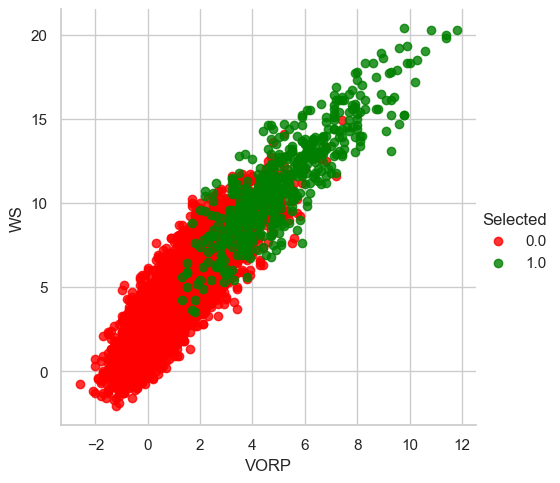

In [17]:
#Win shares (WS) and Value over replacement player (VORP) are two of the most important advanced stats
sns.lmplot(x='VORP', y='WS', hue="Selected", data=final_df, palette={0: "red", 1: "green"}, fit_reg=False)

<Axes: xlabel='WS', ylabel='Density'>

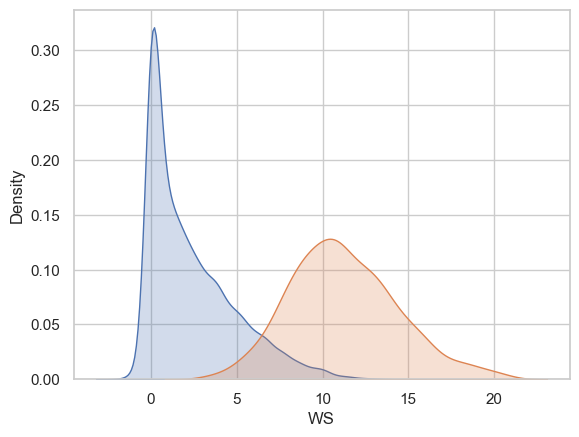

In [18]:
#All-NBA vs rest - Win Shares
sns.kdeplot(final_df['WS'].loc[final_df['Selected'] == 0], shade=True, warn_singular=False)
sns.kdeplot(final_df['WS'].loc[final_df['Selected'] == 1], shade=True, warn_singular=False)

<Axes: xlabel='WS', ylabel='Density'>

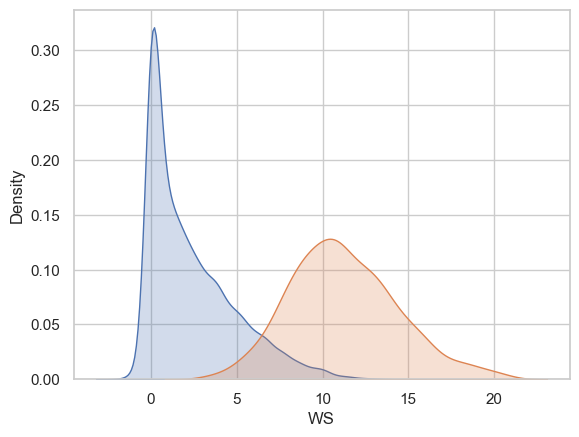

In [19]:
#All-NBA vs rest - Value over replacement player
sns.kdeplot(final_df['WS'].loc[final_df['Selected'] == 0], shade=True, warn_singular=False)
sns.kdeplot(final_df['WS'].loc[final_df['Selected'] == 1], shade=True, warn_singular=False)

<Axes: xlabel='PTS', ylabel='Density'>

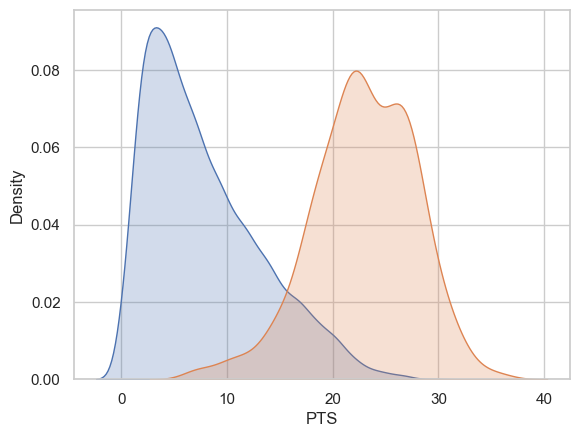

In [20]:
#All-NBA vs rest - Points
sns.kdeplot(final_df['PTS'].loc[final_df['Selected'] == 0], shade=True, warn_singular=False)
sns.kdeplot(final_df['PTS'].loc[final_df['Selected'] == 1], shade=True, warn_singular=False)

The graph below shows the different average values of three selected stats (2-point percentage, 3-point rate, and Free Throw rate) in the start (1989), the middle (2005), and the end (2022) of the examined period.

The values themselves are not important, since they are simple, instead of weighted, averages, but the large differences throughout this period are indicative of the evolution of the game.

We will try to take that into account when standardizing our data, prior to fitting them to our model.

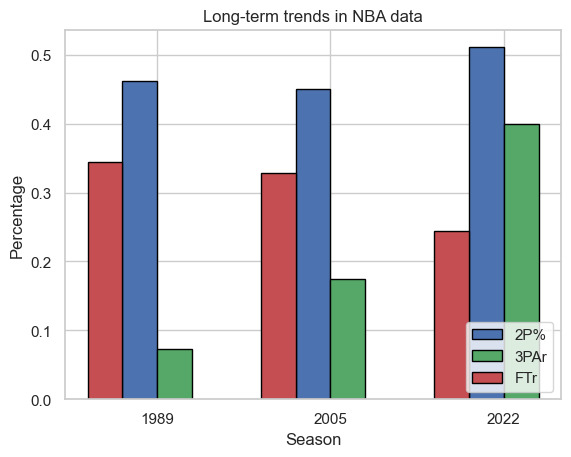

In [21]:
#Years we want to plot
Xyears=[1989,2005,2022]

#initialize "bars"
P2 = []
Pr3 = []
FTr = []
#calculate the values we want to plot
[P2.append(final_df[final_df['Year']==yr]['2P%'].mean()) for yr in Xyears]
[Pr3.append(final_df[final_df['Year']==yr]['3PAr'].mean()) for yr in Xyears]
[FTr.append(final_df[final_df['Year']==yr]['FTr'].mean()) for yr in Xyears]

#define parameters to use in the graph
r = np.arange(len(Xyears))
width = 0.2

#create plot
plt.bar(r, P2, color = 'b', width = 0.2, edgecolor = 'black', label='2P%')
plt.bar(r + 0.2, Pr3, color = 'g', width = 0.2, edgecolor = 'black', label='3PAr')
plt.bar(r - 0.2, FTr, color = 'r', width = 0.2, edgecolor = 'black', label='FTr')
  
plt.xlabel("Season")
plt.ylabel("Percentage")
plt.title("Long-term trends in NBA data")
  
plt.xticks(r + 0.1,Xyears)
plt.legend(loc="lower right")
plt.show()

The last visualisation below is important because it showcases a great imbalance between our classes, which must be taken into consideration for our logistic regression to give accurate predictions.

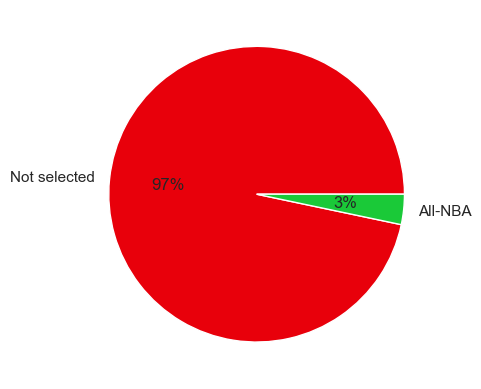

In [22]:
#define Seaborn color palette to use
pieces=final_df['Selected'].value_counts()
colors = sns.color_palette('bright')[3:1:-1]

#create pie chart
plt.pie(pieces, labels = ["Not selected","All-NBA"], colors = colors, autopct='%.0f%%')
plt.show()

# Data Modelling

In [23]:
#import all necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Now we will split our final dataframe into the independent variables (x's), and our dependent variable (responses/classes/y).

In [24]:
#We drop all the other columns except "Year". We will use this column later, to group by it, while standardizing the data.
xdf = final_df.drop(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'Selected'], axis=1)

#change characters to numbers
xdf = xdf.fillna(0)
xdf = xdf.astype(float)
xdf['Year'] = xdf['Year'].astype(int)
xdf

,Year,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48
0,1989,74.0,74.0,22.9,4.2,8.9,0.475,0.0,0.0,0.000,...,0.9,12.9,1.1,11.5,11.0,0.511,20.1,0.0,2.9,0.082
1,1989,62.0,0.0,10.2,0.9,1.8,0.482,0.0,0.0,1.000,...,0.4,8.2,1.5,14.5,13.3,0.507,10.4,-0.2,0.9,0.066
2,1989,77.0,77.0,36.2,6.1,14.1,0.433,2.2,6.1,0.356,...,5.4,17.5,2.7,12.5,5.2,0.567,19.7,3.4,8.3,0.143
3,1989,80.0,76.0,32.5,7.3,15.9,0.461,0.6,2.2,0.293,...,2.4,16.4,0.9,12.6,8.3,0.524,27.4,1.4,4.5,0.082
4,1989,73.0,54.0,32.6,6.6,14.4,0.457,1.6,4.2,0.380,...,5.2,18.0,1.9,11.1,6.0,0.554,22.6,2.7,6.7,0.135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15429,2022,52.0,1.0,16.3,2.7,5.2,0.518,0.3,0.9,0.354,...,0.9,17.0,3.1,15.0,13.1,0.548,17.4,0.9,2.2,0.126
15430,2022,76.0,76.0,34.9,9.4,20.3,0.460,3.1,8.0,0.382,...,9.0,25.4,1.3,14.5,5.9,0.603,34.4,4.8,10.0,0.181
15431,2022,56.0,12.0,12.6,2.3,4.4,0.526,0.0,0.2,0.091,...,0.8,17.4,1.2,13.0,23.6,0.546,19.9,0.2,2.1,0.145
15432,2022,27.0,0.0,13.1,1.9,3.3,0.567,0.0,0.1,0.000,...,0.9,17.2,1.1,14.6,19.3,0.627,15.9,0.0,1.1,0.143


In [25]:
ydf = final_df["Selected"]
ydf.to_frame().astype(int)

,Selected
0,0
1,0
2,0
3,0
4,0
...,...
15429,0
15430,1
15431,0
15432,0


We will now split the data into training (75%) and test data (25%).

In [26]:
#Split data
X_train, X_test, Y_train, Y_test = train_test_split(xdf, ydf, test_size=0.25, random_state=34)

We will group our data by year, before standardizing them, to take into account the different trends around the years that occur as the game evolves.

Also, because of the great imbalance between our classes, we must use a balanced class weight when running the model.

In [27]:
#We will now standardize the data
scaled_X_train = X_train.groupby('Year').transform(lambda x: (x - x.mean()) / x.std())
scaled_X_test = X_test.groupby('Year').transform(lambda x: (x - x.mean()) / x.std())

#Train the model
model = LogisticRegression(class_weight='balanced', max_iter=300 ,random_state = 34).fit(scaled_X_train, Y_train)

#Test the model
sc = model.score(scaled_X_test, Y_test)
print('Acuraccy: ',round(sc*100,4),"%")

Acuraccy:  96.4239 %


The acuraccy of the model is not an unimportant figure, but we're also interested in the breakdown of the predictions. For that reason we will print the confusion matrix of the model.

As we can see in the confusion matrix below, False Negatives are very low (1), while False Positives are significantly high (137).

If we had run the model without balancing the class, we would get a slightly higher accuracy, and fewer False Positives, but we would also get many more False Negatives. By balancing the classes, we put a heavier weight in False Negatives than in False Positives. The ratio of those weights is approximately 97:3, to reflect the ratio of our two classes.

In [28]:
predictions = model.predict(scaled_X_test)
cm = confusion_matrix(Y_test, predictions)
pd.DataFrame(cm, columns = ['Prediction: Not selected', 'All-NBA'])

,Prediction: Not selected,All-NBA
0,3582,137
1,1,139


One of the best plots for a logistic regression model is the receiver operating characteristic curve, or ROC curve.

The larger the area of the upper left triangle is, the higher the quality of the model is. The x=y line represents a model that classifies data points between the two classes, randomly.

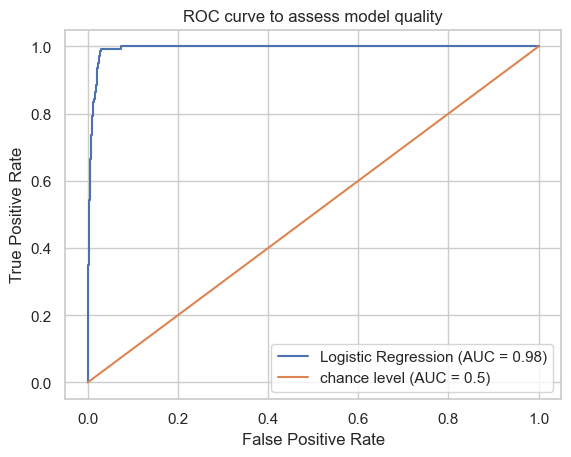

In [29]:
#Plot ROC curve
logit_roc_auc = roc_auc_score(Y_test, model.predict(scaled_X_test))
fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(scaled_X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], label="chance level (AUC = 0.5)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve to assess model quality')
plt.legend()

plt.show()

#Notes:

On this Project, we're not focusing on the model's interpretability, but instead, we want to achieve the highest quality of predictions possible. While working on this project, I tried several feature selection techniques but decided not to include any of them in the final model, because removing so many variables resulted in a drop in performance. 

# Deployment: Use Logistic Regression model as classifier

In [30]:
#import all necessary libraries
from IPython.display import HTML

#More Data Scraping & Data Cleaning

In [31]:
#Load updated 2022-23 player stats
per_game_2023 = find_stats(URL_creator(2023),2023)
advanced_2023 = find_stats(URL_creator(2023, Advanced = True), 2023, Advanced = True)

#Clean data

#merge dataframes
dif_cols = advanced_2023.columns.difference(per_game_2023.columns)
df_2023_New = pd.concat([per_game_2023, advanced_2023[dif_cols]], axis=1)
#Drop empty columns
df_2023_New = df_2023_New.drop(df_2023_New.columns[[-1,-2]], axis=1)
#remove partial (duplicate) rows
df_2023_final = df_2023_New.drop_duplicates(subset=['Player','Year'])

df_2023_final

,Rk,Player,Pos,Age,Tm,Year,G,GS,MP,FG,...,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48
0,1,Precious Achiuwa,C,23,TOR,2023,55,12,20.7,3.6,...,0.8,15.2,1.3,11.4,16.3,.554,19.4,-0.1,2.2,.093
1,2,Steven Adams,C,29,MEM,2023,42,42,27.0,3.7,...,1.3,17.5,1.5,19.8,22.7,.564,14.6,0.7,3.4,.144
2,3,Bam Adebayo,C,25,MIA,2023,75,75,34.6,8.0,...,3.6,20.1,1.7,12.7,15.5,.592,25.2,2.3,7.4,.137
3,4,Ochai Agbaji,SG,22,UTA,2023,59,22,20.5,2.8,...,0.9,9.5,0.6,9.0,5.4,.561,15.8,-0.3,1.3,.053
4,5,Santi Aldama,PF,22,MEM,2023,77,20,21.8,3.2,...,2.1,13.9,1.3,9.3,11.7,.591,16.0,1.1,4.6,.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,535,Thaddeus Young,PF,34,TOR,2023,54,9,14.7,2.0,...,0.7,14.1,3.4,16.7,11.8,.573,13.5,0.4,1.8,.109
675,536,Trae Young,PG,24,ATL,2023,73,73,34.8,8.2,...,5.3,22.0,1.5,15.2,4.7,.573,32.6,3.4,6.7,.126
676,537,Omer Yurtseven,C,24,MIA,2023,9,0,9.2,1.8,...,0.2,16.7,1.2,11.9,16.2,.675,18.0,0.0,0.3,.159
677,538,Cody Zeller,C,30,MIA,2023,15,2,14.5,2.5,...,0.4,16.4,0.7,15.8,17.3,.659,18.1,0.0,0.7,.147


In [32]:
#More data cleaning
df_2023_final = df_2023_final.replace('','0')
df_2023_final = df_2023_final.fillna(0)
df_2023_final.iloc[:, 6::] = df_2023_final.iloc[:, 6::].astype(float)

Although most of the stats in the dataframe are calculated per game, some of them are based on the total amount of games played, therefore, to make accurate predictions, we have to adjust those stats.

Those stats are: Win Shares ('WS') and its components ('OWS' and 'DWS'), Value over replacement player ('VORP'), and of course Games Played ('G') and Games Started ('GS').

In [33]:
Total =['WS', 'OWS', 'DWS', 'VORP', 'GS', 'G']

The simplest way to project those stats into the end of the season would be to divide those stats by the number of games played and then multiply that by 82.

To take into account missed games due to injuries, load management, etc., instead of that, we will calculate the number of games each player has sit out so far, and we will assume that this ratio will stay the same for the rest of the season. Therefore, we will divide the number of games played by the number of games his team has played, and multiply the resulting ratio by 82.

*For players that have changed teams through the season, we will assume that they will play exactly 82 games this season, yet, in reality, the actual number could be lower or, sometimes, higher.

#More Data Scraping & Data Cleaning

In [34]:
# URL to scrape
url = "https://www.basketball-reference.com/leagues/NBA_2023_standings.html#expanded_standings"
# collect HTML data
html = urlopen(url)
# create beautiful soup object from HTML
soup = BeautifulSoup(html, features="lxml")

#Extract information #1
info = soup.findAll('th',scope="row")
#Find the column names
lista=[]
[lista.append(head.text) for head in info]

standings=lista[:30]
teams=[standings[team].split("\xa0")[0] for team in range(len(standings))]
teams = [s.strip('*') for s in teams]
print(teams, end =" ")

['Milwaukee Bucks', 'Boston Celtics', 'Philadelphia 76ers', 'Cleveland Cavaliers', 'New York Knicks', 'Brooklyn Nets', 'Miami Heat', 'Atlanta Hawks', 'Toronto Raptors', 'Chicago Bulls', 'Indiana Pacers', 'Washington Wizards', 'Orlando Magic', 'Charlotte Hornets', 'Detroit Pistons', 'Denver Nuggets', 'Memphis Grizzlies', 'Sacramento Kings', 'Phoenix Suns', 'Los Angeles Clippers', 'Golden State Warriors', 'Los Angeles Lakers', 'Minnesota Timberwolves', 'New Orleans Pelicans', 'Oklahoma City Thunder', 'Dallas Mavericks', 'Utah Jazz', 'Portland Trail Blazers', 'Houston Rockets', 'San Antonio Spurs'] 

In [35]:
#Extract information #2
stats = soup.findAll('td', class_="right")
#Find games played
listb = []
[listb.append(head.text) for head in stats]

#Divide selections per teams
nparray = np.array(listb)
table = nparray.reshape((int(np.shape(nparray)[0]/7),7))
rows = table[:30]
TGP = [int(rows[team][0])+int(rows[team][1]) for team in range(len(rows))]
print(TGP, end =" ")

[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82] 

To find the number of games each player's team has played, we are going to create two dictionaries:

{team name : games played}


{team abbreviation : team name}


In [36]:
#Create first dictionary
team_games = dict(zip(teams,TGP))
print(team_games, end =" ")

{'Milwaukee Bucks': 82, 'Boston Celtics': 82, 'Philadelphia 76ers': 82, 'Cleveland Cavaliers': 82, 'New York Knicks': 82, 'Brooklyn Nets': 82, 'Miami Heat': 82, 'Atlanta Hawks': 82, 'Toronto Raptors': 82, 'Chicago Bulls': 82, 'Indiana Pacers': 82, 'Washington Wizards': 82, 'Orlando Magic': 82, 'Charlotte Hornets': 82, 'Detroit Pistons': 82, 'Denver Nuggets': 82, 'Memphis Grizzlies': 82, 'Sacramento Kings': 82, 'Phoenix Suns': 82, 'Los Angeles Clippers': 82, 'Golden State Warriors': 82, 'Los Angeles Lakers': 82, 'Minnesota Timberwolves': 82, 'New Orleans Pelicans': 82, 'Oklahoma City Thunder': 82, 'Dallas Mavericks': 82, 'Utah Jazz': 82, 'Portland Trail Blazers': 82, 'Houston Rockets': 82, 'San Antonio Spurs': 82} 

In [37]:
#Create list of team abbreviations from 2023 stats dataframe
Abbs = list(np.unique(df_2023_final['Tm']))
#'TOT' doesn't correspond to a team name, it is used for players that have played for more than one team
Abbs.remove('TOT')
#"CHO" and "CHI" are the only abbrevations that don't follow the same alphabetical order as their corresponding team names
Abbs[3]="CHO"
Abbs[4]="CHI"

In [38]:
#Create second dictionary
teams.sort()
team_abbs = dict(zip(Abbs, teams))
print(team_abbs, end =" ")

{'ATL': 'Atlanta Hawks', 'BOS': 'Boston Celtics', 'BRK': 'Brooklyn Nets', 'CHO': 'Charlotte Hornets', 'CHI': 'Chicago Bulls', 'CLE': 'Cleveland Cavaliers', 'DAL': 'Dallas Mavericks', 'DEN': 'Denver Nuggets', 'DET': 'Detroit Pistons', 'GSW': 'Golden State Warriors', 'HOU': 'Houston Rockets', 'IND': 'Indiana Pacers', 'LAC': 'Los Angeles Clippers', 'LAL': 'Los Angeles Lakers', 'MEM': 'Memphis Grizzlies', 'MIA': 'Miami Heat', 'MIL': 'Milwaukee Bucks', 'MIN': 'Minnesota Timberwolves', 'NOP': 'New Orleans Pelicans', 'NYK': 'New York Knicks', 'OKC': 'Oklahoma City Thunder', 'ORL': 'Orlando Magic', 'PHI': 'Philadelphia 76ers', 'PHO': 'Phoenix Suns', 'POR': 'Portland Trail Blazers', 'SAC': 'Sacramento Kings', 'SAS': 'San Antonio Spurs', 'TOR': 'Toronto Raptors', 'UTA': 'Utah Jazz', 'WAS': 'Washington Wizards'} 

Using the two dictionarys we created above, we will create a new column to store the number of team games for each player, by applying the function defined below.

In [39]:
#Define function to adjust stats
def team_games_finder(team):
    return (0 if team=='TOT' else int(team_games[team_abbs[team]]))
    
#Apply the function
df_2023_temp = df_2023_final.copy()
df_2023_temp['Team Games'] = df_2023_temp['Tm'].map(team_games_finder)

Now, to project the stats mentioned earlier into the end of the season, we will have to perform the following operations, while treating the cases of "multi-team" players separately.

In [40]:
#First we split the two cases into two dataframes
df_2023_adj = df_2023_temp[df_2023_temp['Team Games']>0]
df_2023_adj0 = df_2023_temp[df_2023_temp['Team Games']==0]

#In each of those stats we apply the calculations stated earlier, while implementing the following mathematical simplifications:

#General case: (stat/player games)*(player games/team games)*82 = (stat/team games)*82
#"multi-team" players case: (stat/player games)*(player games/team games)*82 = (stat/player games)*82

for stat in Total:
    df_2023_adj[stat] = df_2023_adj[stat].divide(df_2023_adj['Team Games'])*82
    df_2023_adj0[stat] = df_2023_adj0[stat].divide(df_2023_adj0['G'])*82
    #It is important for the Games played column to be the last one to be transformed,
    #so that it can be used to transfrom the other columns, prior to itself.

#Finally we merge the two cases into one and restore index order
X_2023 = pd.concat([df_2023_adj, df_2023_adj0])
X_2023.sort_index()

,Rk,Player,Pos,Age,Tm,Year,G,GS,MP,FG,...,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,Team Games
0,1,Precious Achiuwa,C,23,TOR,2023,55.0,12.0,20.7,3.6,...,15.2,1.3,11.4,16.3,0.554,19.4,-0.1,2.2,0.093,82
1,2,Steven Adams,C,29,MEM,2023,42.0,42.0,27.0,3.7,...,17.5,1.5,19.8,22.7,0.564,14.6,0.7,3.4,0.144,82
2,3,Bam Adebayo,C,25,MIA,2023,75.0,75.0,34.6,8.0,...,20.1,1.7,12.7,15.5,0.592,25.2,2.3,7.4,0.137,82
3,4,Ochai Agbaji,SG,22,UTA,2023,59.0,22.0,20.5,2.8,...,9.5,0.6,9.0,5.4,0.561,15.8,-0.3,1.3,0.053,82
4,5,Santi Aldama,PF,22,MEM,2023,77.0,20.0,21.8,3.2,...,13.9,1.3,9.3,11.7,0.591,16.0,1.1,4.6,0.13,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,535,Thaddeus Young,PF,34,TOR,2023,54.0,9.0,14.7,2.0,...,14.1,3.4,16.7,11.8,0.573,13.5,0.4,1.8,0.109,82
675,536,Trae Young,PG,24,ATL,2023,73.0,73.0,34.8,8.2,...,22.0,1.5,15.2,4.7,0.573,32.6,3.4,6.7,0.126,82
676,537,Omer Yurtseven,C,24,MIA,2023,9.0,0.0,9.2,1.8,...,16.7,1.2,11.9,16.2,0.675,18.0,0.0,0.3,0.159,82
677,538,Cody Zeller,C,30,MIA,2023,15.0,2.0,14.5,2.5,...,16.4,0.7,15.8,17.3,0.659,18.1,0.0,0.7,0.147,82


Next, we will feed our independent variables (x's) to the model to get a probability assigned to each player.

In [41]:
#Only keep independent variable columns
new_data = X_2023.iloc[:, 5:-1:]

#Scale the data before feeding them to the model
scaled_X_new = new_data.groupby('Year').transform(lambda x: (x - x.mean()) / x.std())

#Create All-NBA selection probability column
X_2023['Prediction_prob(%)'] = (model.predict_proba(scaled_X_new)[:,1:]).round(4)

In [42]:
#Print the 15 players with the highest probability of being selected
OUT = X_2023[['Player','Pos','Age','Tm','Prediction_prob(%)']].sort_values(by=['Prediction_prob(%)'], ascending=False).head(15)
HTML(OUT.to_html(index=False))

Player,Pos,Age,Tm,Prediction_prob(%)
Joel Embiid,C,28,PHI,1.0000
Nikola Jokić,C,27,DEN,1.0000
Kevin Durant,PF,34,TOT,0.9999
Jayson Tatum,SF,24,BOS,0.9999
Giannis Antetokounmpo,PF,28,MIL,0.9999
Luka Dončić,PG,23,DAL,0.9998
Shai Gilgeous-Alexander,PG,24,OKC,0.9995
Anthony Davis,C,29,LAL,0.9984
Jimmy Butler,PF,33,MIA,0.9981
Damian Lillard,PG,32,POR,0.9979
